In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

469it [00:03, 126.11it/s]


Epoch 1, Loss: 837.34
Accuracy: 85.59%



469it [00:03, 127.82it/s]


Epoch 2, Loss: 733.70
Accuracy: 94.57%



469it [00:03, 120.29it/s]


Epoch 3, Loss: 715.97
Accuracy: 95.22%



469it [00:03, 127.99it/s]


Epoch 4, Loss: 711.81
Accuracy: 95.83%



469it [00:03, 125.86it/s]


Epoch 5, Loss: 709.18
Accuracy: 95.90%



469it [00:03, 127.49it/s]


Epoch 6, Loss: 707.44
Accuracy: 95.88%



469it [00:03, 127.15it/s]


Epoch 7, Loss: 706.12
Accuracy: 95.99%



469it [00:03, 128.27it/s]


Epoch 8, Loss: 705.06
Accuracy: 96.21%



469it [00:03, 128.59it/s]


Epoch 9, Loss: 704.43
Accuracy: 96.50%



469it [00:03, 128.49it/s]


Epoch 10, Loss: 703.57
Accuracy: 96.57%



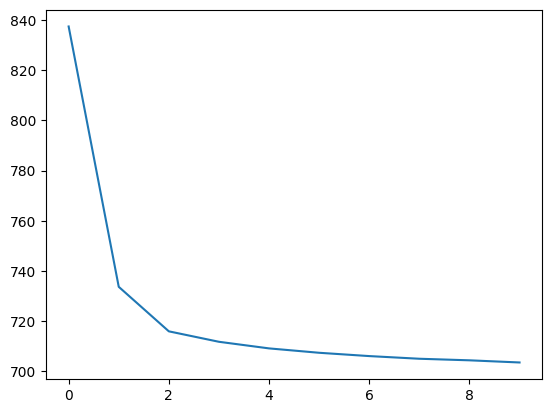

In [3]:
from tiny_cnn_model import TinyCNN
        
model = TinyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.007)

test_data = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

losses = []
for epoch in range(10):
    epoch_loss = 0
    for i, (X, y) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.2f}")
    losses.append(epoch_loss)

    # test set accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_loader:
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    print(f"Accuracy: {correct/total *100:.2f}%\n")

torch.save(model, "tiny_mnist_cnn.pth")

plt.plot(losses)
plt.show()

tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)


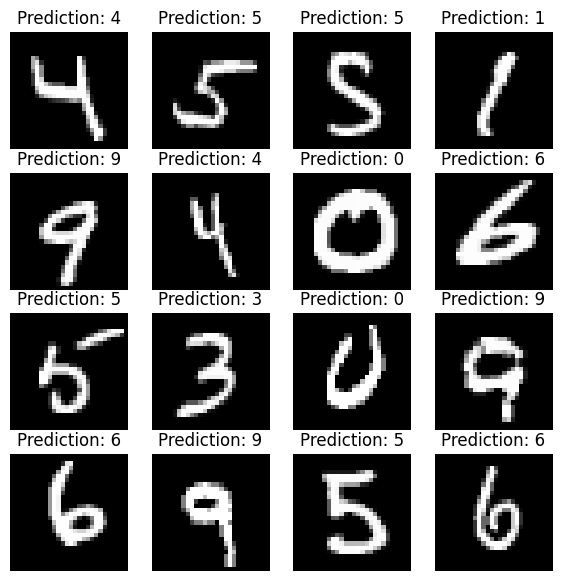

In [13]:
plt.figure(figsize=(7, 7))
for i in range(16):
    idx = random.randint(0, len(test_data))

    X = test_data[idx][0].unsqueeze(0)
    y = test_data[idx][1]

    y_pred = model(X)

    plt.subplot(4, 4, i+1)

    plt.imshow(X.squeeze().numpy(), cmap="gray")
    plt.title(f"Prediction: {y_pred.argmax(1).item()}")
    plt.axis("off")
plt.show()

# Visualization

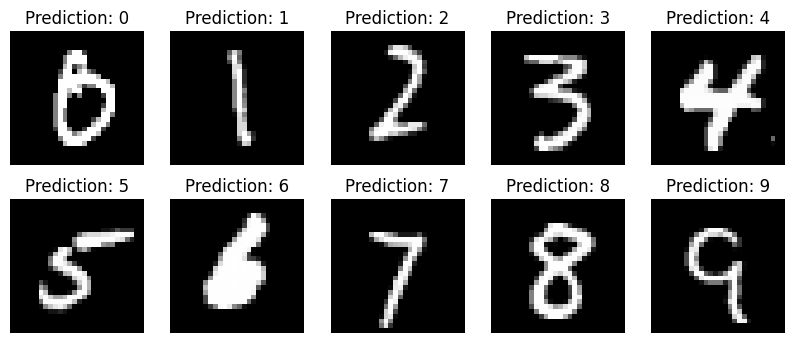

In [8]:
inputs = {}
while True:
    i = random.randint(0, len(test_data))
    y = test_data[i][1]
    if y not in inputs.keys():
        inputs[y] = test_data[i][0].unsqueeze(0)

    if len(inputs.keys()) == 10:
        break
        
plt.figure(figsize=(10, 4))
for i in range(10):
    X = inputs[i]
    y_pred = model(X)
    plt.subplot(2, 5, i+1)
    plt.imshow(X.squeeze().numpy(), cmap="gray")
    plt.title(f"Prediction: {y_pred.argmax(1).item()}")
    plt.axis("off")


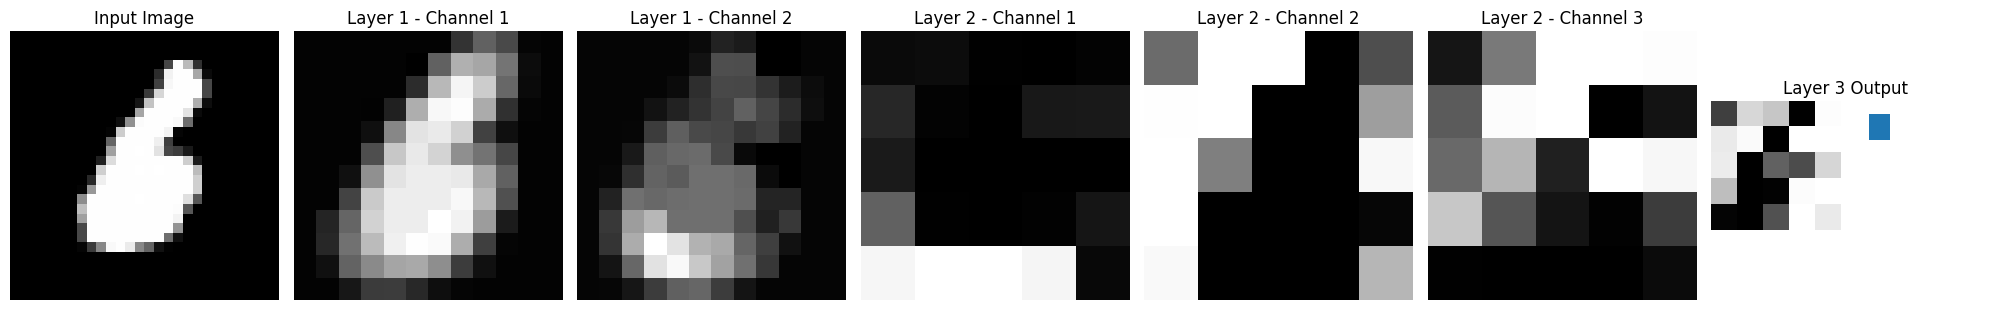

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

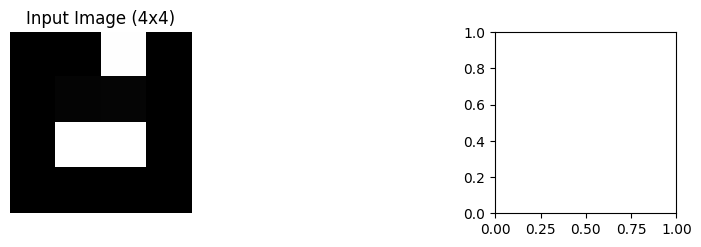

In [25]:
inp = inputs[6]

layer_1 = model.conv1(inp)
layer_1 = torch.relu(layer_1)
layer_1 = torch.max_pool2d(layer_1, 2)

layer_2 = model.conv2(layer_1)
layer_2 = torch.sigmoid(layer_2)
layer_2 = torch.max_pool2d(layer_2, 2)

layer_3 = layer_2.view(-1, 100)
layer_3 = model.fc(layer_3)
layer_3 = torch.softmax(layer_3, dim=1)
plt.figure(figsize=(20, 5))

# Input image
plt.subplot(1, 7, 1)
plt.imshow(inp.squeeze().numpy(), cmap="gray")
plt.title("Input Image")
plt.axis("off")

# Layer 1
for i in range(2):
    plt.subplot(1, 7, 2 + i)
    plt.imshow(layer_1.squeeze()[i].detach().numpy(), cmap="gray")
    plt.title(f"Layer 1 - Channel {i+1}")
    plt.axis("off")

# Layer 2
for i in range(4):
    plt.subplot(1, 7, 4 + i)
    plt.imshow(layer_2.squeeze()[i].detach().numpy(), cmap="gray")
    plt.title(f"Layer 2 - Channel {i+1}")
    plt.axis("off")

# Layer 3
plt.subplot(1, 7, 7)
plt.bar(range(10), layer_3.squeeze().detach().numpy())
plt.xticks(range(10))
plt.title("Layer 3 Output")
plt.yticks([])

plt.tight_layout()
plt.show()
import torch.nn.functional as F

# Create figure
plt.figure(figsize=(15, 5))

# Input (4x4)
plt.subplot(1, 3, 1)
inp_resized = F.interpolate(inp, size=(4, 4), mode='bilinear', align_corners=False)
plt.imshow(inp_resized.squeeze().numpy(), cmap="gray")
plt.title("Input (4x4)")
plt.axis("off")

# Layer 1 (2x2 x 2 channels)
plt.subplot(1, 3, 2)
layer1_grid = torch.zeros(4, 4)  # 2x2 grid for each channel
for i in range(2):
    channel = layer_1.squeeze()[i]
    channel_resized = F.interpolate(channel.unsqueeze(0).unsqueeze(0), size=(2, 2), mode='bilinear', align_corners=False)
    layer1_grid[i*2:(i+1)*2, :] = channel_resized.squeeze()
plt.imshow(layer1_grid.numpy(), cmap="gray")
plt.title("Layer 1 (2 channels)")
plt.axis("off")

# Layer 2 (1x1 x 4 channels)
plt.subplot(1, 3, 3)
layer2_grid = torch.zeros(1, 4)  # 1x1 grid for each channel
for i in range(4):
    channel = layer_2.squeeze()[i]
    channel_resized = F.interpolate(channel.unsqueeze(0).unsqueeze(0), size=(1, 1), mode='bilinear', align_corners=False)
    layer2_grid[0, i] = channel_resized.squeeze()
plt.imshow(layer2_grid.numpy(), cmap="gray")
plt.title("Layer 2 (4 channels)")
plt.axis("off")

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()